In [8]:
from ramandecompy import spectrafit
from ramandecompy import dataprep
import h5py
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate
from lmfit.models import PseudoVoigtModel

In [ ]:
hdf5_file = 'ramandecompy/tests/test_files/dataprep_experiment.hdf5'
key = '300C/25s'
hdf5 = h5py.File(hdf5_file, 'r')
x_data = list(hdf5['{}/{}'.format(key, 'wavenumber')])
y_data = list(hdf5['{}/{}'.format(key, 'counts')])

In [ ]:
fig, ax = dataprep.plot_fit(hdf5_file, key)
plt.axvline(x=1280, color='orange')

develop a new function that will refit the data using the original fit plus a dictionary of custom locations. The dictionary elements with either be integer wavenumbers, or string Peak_#s, followed by how many peaks should be applied to that location.

In [ ]:
# extract peak center and height locations from hdf5
peaks = []
for _,peak in enumerate(list(hdf5[key])[:-2]):
    peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
peaks

In [ ]:
from scipy import interpolate
# specify a peaks to add manually
peak_loc = [1350, 1385]
# interpolate data
comp_int = interpolate.interp1d(x_data, y_data, kind='cubic')
# iterate through peak_loc
peaks_add = []
for _,guess in enumerate(peak_loc):
    height = comp_int(int(guess))
    peaks_add.append((int(guess), int(height)))
peaks_add

In [ ]:
from lmfit.models import PseudoVoigtModel

mod, pars = spectrafit.set_params(peaks)
peak_list = []
for i, _ in enumerate(peaks_add):
    prefix = 'p{}_'.format(i+1+len(peaks))
    peak = PseudoVoigtModel(prefix=prefix)
    pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks_add[i][0], vary=True, min=(peaks_add[i][0]-10), max=(peaks_add[i][0]+10))
    pars[prefix+'height'].set(min=0.1*peaks_add[i][1])
    pars[prefix+'sigma'].set(100, min=1, max=150)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    mod = mod + peak_list[i]

In [ ]:
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

In [ ]:
import numpy as np
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

now to explore a bit with loosening the sensitivity of the automatic functions to detect too many peaks and then remove those with too small of an area to contribute

In [ ]:
# peaks = spectrafit.peak_detect(x_data, y_data, height=(0.02*max(y_data)), prominence=(0.01*max(y_data)))[0]
# len(peaks)
# extract peak center and height locations from hdf5
peaks = []
for _,peak in enumerate(list(hdf5[key])[:-2]):
    peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
peaks

In [ ]:
mod, pars = spectrafit.set_params(peaks)
out = spectrafit.model_fit(x_data, y_data, mod, pars)
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

In [18]:
dataprep.add_experiment(hdf5_file, 'ramandecompy/tests/test_files/FA_3.6wt__300C_25s.csv')

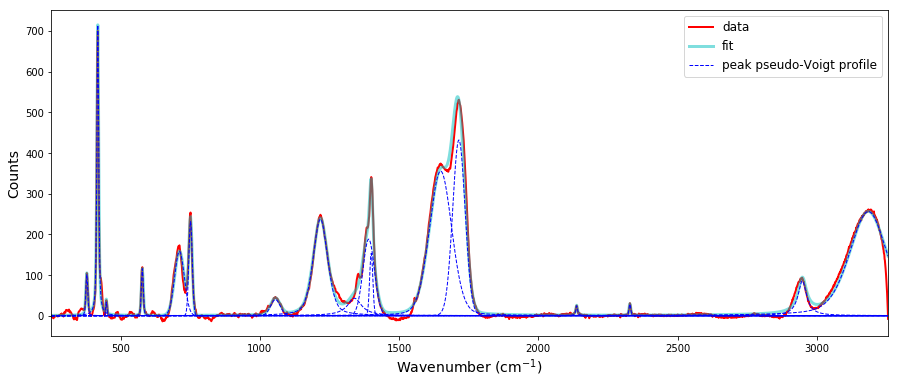

TypeError: 'ModelResult' object is not iterable

In [14]:
add_list = [1350, 1385]
drop_list = ['Peak_01']
hdf5_file = 'ramandecompy/tests/test_files/dataprep_experiment.hdf5'
key = '300C/25s'
# def custom_peaks(add_list, drop_list=None)
# open hdf5_file
hdf5 = h5py.File(hdf5_file, 'r+')
# extract raw x-y data
x_data = np.asarray(hdf5['{}/{}'.format(key, 'wavenumber')])
y_data = np.asarray(hdf5['{}/{}'.format(key, 'counts')])
# extract peak center and height locations from hdf5
peaks = []
for _,peak in enumerate(list(hdf5[key])[:-2]):
    peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
# drop desired tuples from peaks
if drop_list is not None:
    drop_index = []
    for _,name in enumerate(drop_list):
        drop_index.append(int(name.split('_')[-1])-1)
    for i,index in enumerate(drop_index):
        peaks.pop(index-i)      
else:
    pass
# interpolate data
comp_int = interpolate.interp1d(x_data, y_data, kind='cubic')
# iterate through add_list
peaks_add = []
for _,guess in enumerate(add_list):
    height = comp_int(int(guess))
    peaks_add.append((int(guess), int(height)))
# add new list of peaks to model
mod, pars = spectrafit.set_params(peaks)
peak_list = []
for i, _ in enumerate(peaks_add):
    prefix = 'p{}_'.format(i+1+len(peaks))
    peak = PseudoVoigtModel(prefix=prefix)
    pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks_add[i][0], vary=True, min=(peaks_add[i][0]-10), max=(peaks_add[i][0]+10))
    pars[prefix+'height'].set(min=0.1*peaks_add[i][1])
    pars[prefix+'sigma'].set(100, min=1, max=150)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    mod = mod + peak_list[i] 
# run the fit
out = spectrafit.model_fit(x_data, y_data, mod, pars)
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)
# save fit data
fit_result = export_fit_data(x_data, out)
# delete old fit data
del hdf5['300C/25s']
# write data to .hdf5
hdf5['{}/wavenumber'.format(key)] = x_data
hdf5['{}/counts'.format(key)] = y_data
for i, _ in enumerate(fit_result):
    if i < 9:
        hdf5['{}/Peak_0{}'.format(key, i+1)] = fit_result[i]
    else:
        hdf5['{}/Peak_{}'.format(key, i+1)] = fit_result[i]

In [19]:
dataprep.view_hdf5(hdf5_file)

**** ramandecompy/tests/test_files/dataprep_experiment.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    wavenumber
